# DAV 6150 Project 1 (Module 6)

# Avi Skidelsky
# Liu Qianwen
# Mark Kaplan

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer
import seaborn as sns

### Bring in Data and Comment On its Structure:
We bring in the dataset from github and show that there are 29 columns and around 73,000 observations. Out of these columns, 5 are int and 24 are str. Note that all of the 5 int columns are categorical and those ints should be changed to str so there is no confusion. Furthermore, the 17 numeric columns are all stored as str and will need to be converted to int to be able to do anything with them. 

**Attribute Information**

1. report_school_year: Indicates school year for which high school graduation info is being reported
2. aggregation_index: Numeric code identifying manner in which high school graduation data has been aggregated
3. aggregation_type: Text description of how high school graduation data has been aggregated
4. nrc_code: Numeric code identifying "needs / resource capacity", which is an indicator of the type of school district
5. nrc_desc: Text description of the type of school district
6. county_code: Numeric code for county name
7. county_name: Full name of applicable NY State county
8. nyc_ind: Indicates whether or not the school district resides within the borders of NYC
9. membership_desc: Indicates school year in which students first enrolled in High School
10. subgroup_code: Numeric code identifying student subgrouping
11. subgroup_name: Text description of student subgrouping. Note that a student may belong to MORE THAN ONE subgrouping (e.g., "Female", "Hispanic", "Not English Language Learner", etc.)
12. enroll_cnt: How many students of the indicated subgrouping were enrolled during the given school year
13. grad_cnt: How many enrolled students of the indicated subgrouping graduated at the end of the given school year
14. grad_pct: What percentage of enrolled students of the indicated subgrouping graduated at the end for the given school year
15. local_cnt: How many enrolled students of the indicated subgrouping were awarded a "Local" diploma
16. local_pct: What percentage of enrolled students of the indicated subgrouping were awarded a "Local" diploma
17. reg_cnt: How many enrolled students of the indicated subgrouping were awarded a "Regents" diploma
18. reg_pct: What percentage of enrolled students of the indicated subgrouping were awarded a "Regents" diploma
19. reg_adv_cnt: How many enrolled students of the indicated subgrouping were awarded a "Regents Advanced" diploma
20. reg_adv_pct: What percentage of enrolled students of the indicated subgrouping were awarded a "Regents Advanced" diploma
21. non_diploma_credential_cnt: How many enrolled students of the indicated subgrouping achieved a non-diploma credential
22. non_diploma_credential_pct: What percentage of enrolled students of the indicated subgrouping achieved a non-diploma credential
23. still_enrolled_cnt: How many enrolled students of the indicated subgrouping did not graduate but were still_enrolled
24. still_enrolled_pct: What percentage of enrolled students of the indicated subgrouping did not graduate but were still_enrolled
25. ged_cnt: How many enrolled students of the indicated subgrouping were awarded a "GED" diploma
26. ged_pct: What percentage of enrolled students of the indicated subgrouping were awarded a "GED" diploma
27. dropout_cnt: How many enrolled students of the indicated subgrouping discontinued their high school enrollment during the school year
28. dropout_pct: What percentage of enrolled students of the indicated subgrouping discontinued their high school enrollment during the school year


In [2]:
raw_data = pd.read_csv('https://raw.githubusercontent.com/askidelsky/DAV-6150/main/Homework/Project%201/Project1_Data.csv')
raw_data.head()

,report_school_year,aggregation_index,aggregation_type,aggregation_name,nrc_code,nrc_desc,county_code,county_name,nyc_ind,membership_desc,...,reg_adv_cnt,reg_adv_pct,non_diploma_credential_cnt,non_diploma_credential_pct,still_enr_cnt,still_enr_pct,ged_cnt,ged_pct,dropout_cnt,dropout_pct
0,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,...,91,14%,16,2%,30,5%,0,0%,148,22%
1,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,...,47,15%,2,1%,11,3%,0,0%,65,20%
2,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,...,44,13%,14,4%,19,6%,0,0%,83,25%
3,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,...,-,-,-,-,-,-,-,-,-,-
4,2018-19,3,District,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,...,23,6%,10,3%,18,5%,0,0%,91,25%


In [3]:
raw_data.shape

(73152, 29)

In [4]:
types = {}
for i in range(len(raw_data.columns)):
    types[raw_data.columns[i]] = type(raw_data.iloc[0,i])
types

{'report_school_year': str,
 'aggregation_index': numpy.int64,
 'aggregation_type': str,
 'aggregation_name': str,
 'nrc_code': numpy.int64,
 'nrc_desc': str,
 'county_code': numpy.int64,
 'county_name': str,
 'nyc_ind': numpy.int64,
 'membership_desc': str,
 'subgroup_code': numpy.int64,
 'subgroup_name': str,
 'enroll_cnt': str,
 'grad_cnt': str,
 'grad_pct': str,
 'local_cnt': str,
 'local_pct': str,
 'reg_cnt': str,
 'reg_pct': str,
 'reg_adv_cnt': str,
 'reg_adv_pct': str,
 'non_diploma_credential_cnt': str,
 'non_diploma_credential_pct': str,
 'still_enr_cnt': str,
 'still_enr_pct': str,
 'ged_cnt': str,
 'ged_pct': str,
 'dropout_cnt': str,
 'dropout_pct': str}

### Exploratory Data Analysis: Profiling Data and Cleaning Up
Using domain knowledge, we can see that there are a significant number of categorical variable so it only makes sense for us to see if there are any that can be eliminated since they are the same. Through a list of unique values for each categorical variable we can see that report_school_year, aggregation_index, and aggregation_type can all be removed since they are all one uniform value each.

In [5]:
cats = raw_data[['report_school_year','aggregation_index','aggregation_type','aggregation_name','nrc_code','nrc_desc','county_code',
         'county_name','nyc_ind','membership_desc','subgroup_code','subgroup_name']]

vals = {}
for i in range(len(cats.columns)):
    vals[cats.columns[i]] = cats.iloc[:,i].unique()
vals

{'report_school_year': array(['2018-19'], dtype=object),
 'aggregation_index': array([3], dtype=int64),
 'aggregation_type': array(['District'], dtype=object),
 'aggregation_name': array(['ALBANY CITY SCHOOL DISTRICT',
        'BERNE-KNOX-WESTERLO CENTRAL SCHOOL DISTRICT',
        'BETHLEHEM CENTRAL SCHOOL DISTRICT',
        'RAVENA-COEYMANS-SELKIRK CENTRAL SCHOOL DISTRICT',
        'COHOES CITY SCHOOL DISTRICT',
        'SOUTH COLONIE CENTRAL SCHOOL DISTRICT', 'NORTH COLONIE CSD',
        'GREEN ISLAND UNION FREE SCHOOL DISTRICT',
        'GUILDERLAND CENTRAL SCHOOL DISTRICT',
        'VOORHEESVILLE CENTRAL SCHOOL DISTRICT',
        'WATERVLIET CITY SCHOOL DISTRICT',
        'ALFRED-ALMOND CENTRAL SCHOOL DISTRICT',
        'ANDOVER CENTRAL SCHOOL DISTRICT',
        'GENESEE VALLEY CENTRAL SCHOOL DISTRICT',
        'BELFAST CENTRAL SCHOOL DISTRICT',
        'CANASERAGA CENTRAL SCHOOL DISTRICT',
        'FRIENDSHIP CENTRAL SCHOOL DISTRICT',
        'FILLMORE CENTRAL SCHOOL DISTRICT',
  

In [6]:
raw_data.drop(columns=['report_school_year','aggregation_index','aggregation_type'], inplace=True)

We can also see through domain knowledge that there are some columns that mean the same thing, specifically the codes that correspond to text, these can be deleted without losing information. We keep the text columns so that if we would potentially include these categorical variables in the future the dummies that we construct will be easier to interpret. Note, they will be dropped later so that they can be used for EDA on missing values.

Most importantly before doing any EDA is dealing with any missing data. Unfortunately, our dataset contains a huge amount of missing data, specifically close to 46% of all observations are missing data. Note that thanks to the code below, we can see that the observations that are lacking any observations are lacking all numeric observations. Due to this, we can't impute this numeric data from others. We can see due to the value counts that it looks like the missing values are really skewed to a couple specific codes and therefore are likely left out on purpose. This can be further assumed since all numeric attributes are lost and not just one or two. For this reason, we felt comfortable leaving these columns out. Now we can delete the code type columns that were discussed earlier.

In [7]:
lst = 0
for i in range(len(raw_data)):
    if raw_data.enroll_cnt[i].isnumeric()==False and raw_data.grad_cnt[i].isnumeric()==False and raw_data.local_cnt[i].isnumeric()==False and raw_data.reg_cnt[i].isnumeric()==False and raw_data.reg_adv_cnt[i].isnumeric()==False and raw_data.non_diploma_credential_cnt[i].isnumeric()==False and raw_data.still_enr_cnt[i].isnumeric()==False and raw_data.ged_cnt[i].isnumeric()==False and raw_data.dropout_cnt[i].isnumeric()==False:
        lst += 1
print('Missing Values: ',lst, 'Percentage Missing: ',round((lst/len(raw_data))*100,2),'%')

Missing Values:  33478 Percentage Missing:  45.76 %


In [8]:
clean_data = raw_data.drop(raw_data[raw_data['enroll_cnt']=='-'].index)
clean_data.head()

,aggregation_name,nrc_code,nrc_desc,county_code,county_name,nyc_ind,membership_desc,subgroup_code,subgroup_name,enroll_cnt,...,reg_adv_cnt,reg_adv_pct,non_diploma_credential_cnt,non_diploma_credential_pct,still_enr_cnt,still_enr_pct,ged_cnt,ged_pct,dropout_cnt,dropout_pct
0,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,1,All Students,658,...,91,14%,16,2%,30,5%,0,0%,148,22%
1,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,2,Female,324,...,47,15%,2,1%,11,3%,0,0%,65,20%
2,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,3,Male,334,...,44,13%,14,4%,19,6%,0,0%,83,25%
4,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,5,Black,367,...,23,6%,10,3%,18,5%,0,0%,91,25%
5,ALBANY CITY SCHOOL DISTRICT,3,Urban-Suburban High Needs,1,ALBANY,0,2013 Total Cohort - 6 Year Outcome,6,Hispanic,98,...,5,5%,4,4%,8,8%,0,0%,28,29%


In [9]:
clean_data.drop(columns=['nrc_code','county_code','subgroup_code'], inplace=True)

Now moving on to the numeric data, we will need to change these from str to int as established before. Additionally, all of the "pct" columns are written in text but are calculated by dividing the corresponding "cnt" column by enroll_cnt so these can be recreated later and those values will be able to be used in models if needed. All of this can be seen in the sample observation below and are corrected in the following code blocks.

In [10]:
clean_data['grad_pct']=clean_data['grad_pct'].str.strip("%").astype(float)/100;
clean_data['local_pct']=clean_data['local_pct'].str.strip("%").astype(float)/100;
clean_data['reg_pct']=clean_data['reg_pct'].str.strip("%").astype(float)/100;
clean_data['reg_adv_pct']=clean_data['reg_adv_pct'].str.strip("%").astype(float)/100;
clean_data['non_diploma_credential_pct']=clean_data['non_diploma_credential_pct'].str.strip("%").astype(float)/100;
clean_data['still_enr_pct']=clean_data['still_enr_pct'].str.strip("%").astype(float)/100;
clean_data['ged_pct']=clean_data['ged_pct'].str.strip("%").astype(float)/100;
clean_data['dropout_pct']=clean_data['dropout_pct'].str.strip("%").astype(float)/100;

In [11]:
clean_data['enroll_cnt']=clean_data['enroll_cnt'].astype(float)
clean_data['grad_cnt']=clean_data['grad_cnt'].astype(float)
clean_data['local_cnt']=clean_data['local_cnt'].astype(float)
clean_data['reg_cnt']=clean_data['reg_cnt'].astype(float)
clean_data['reg_adv_cnt']=clean_data['reg_adv_cnt'].astype(float)
clean_data['non_diploma_credential_cnt']=clean_data['non_diploma_credential_cnt'].astype(float)
clean_data['still_enr_cnt']=clean_data['still_enr_cnt'].astype(float)
clean_data['ged_cnt']=clean_data['ged_cnt'].astype(float)
clean_data['dropout_cnt']=clean_data['dropout_cnt'].astype(float)
clean_data.dtypes

aggregation_name               object
nrc_desc                       object
county_name                    object
nyc_ind                         int64
membership_desc                object
subgroup_name                  object
enroll_cnt                    float64
grad_cnt                      float64
grad_pct                      float64
local_cnt                     float64
local_pct                     float64
reg_cnt                       float64
reg_pct                       float64
reg_adv_cnt                   float64
reg_adv_pct                   float64
non_diploma_credential_cnt    float64
non_diploma_credential_pct    float64
still_enr_cnt                 float64
still_enr_pct                 float64
ged_cnt                       float64
ged_pct                       float64
dropout_cnt                   float64
dropout_pct                   float64
dtype: object

### EDA: Descriptive Statistics and Distributions
Now that all the data is in its proper form and missing values are removed, we can start to move on to our further analysis.

In [12]:
clean_data.iloc[:,6:].describe()

,enroll_cnt,grad_cnt,grad_pct,local_cnt,local_pct,reg_cnt,reg_pct,reg_adv_cnt,reg_adv_pct,non_diploma_credential_cnt,non_diploma_credential_pct,still_enr_cnt,still_enr_pct,ged_cnt,ged_pct,dropout_cnt,dropout_pct
count,39674.000000,39674.000000,39674.000000,39674.000000,39674.000000,39674.000000,39674.000000,39674.000000,39674.000000,39674.000000,39674.000000,39674.000000,39674.000000,39674.000000,39674.000000,39674.000000,39674.000000
mean,192.120079,161.178354,0.844066,12.340903,0.084799,86.804708,0.433711,62.032742,0.325772,1.924485,0.017426,11.299516,0.051907,1.377577,0.006127,16.239225,0.079630
std,439.972474,361.294773,0.156795,32.046302,0.103985,225.795826,0.171249,132.777866,0.230012,6.498913,0.040640,40.766672,0.088327,4.949389,0.019854,50.129834,0.096587
min,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,20.000000,0.790000,1.000000,0.020000,10.000000,0.330000,4.000000,0.140000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.010000
50%,66.000000,57.000000,0.890000,4.000000,0.060000,27.000000,0.430000,18.000000,0.310000,0.000000,0.000000,2.000000,0.020000,0.000000,0.000000,3.000000,0.050000
75%,179.000000,156.000000,0.950000,10.000000,0.110000,69.000000,0.530000,62.000000,0.490000,2.000000,0.020000,5.000000,0.060000,1.000000,0.000000,9.000000,0.110000
max,9176.000000,7540.000000,1.000000,557.000000,1.000000,4752.000000,1.000000,2231.000000,1.000000,279.000000,0.670000,1381.000000,1.000000,97.000000,0.670000,1091.000000,1.000000


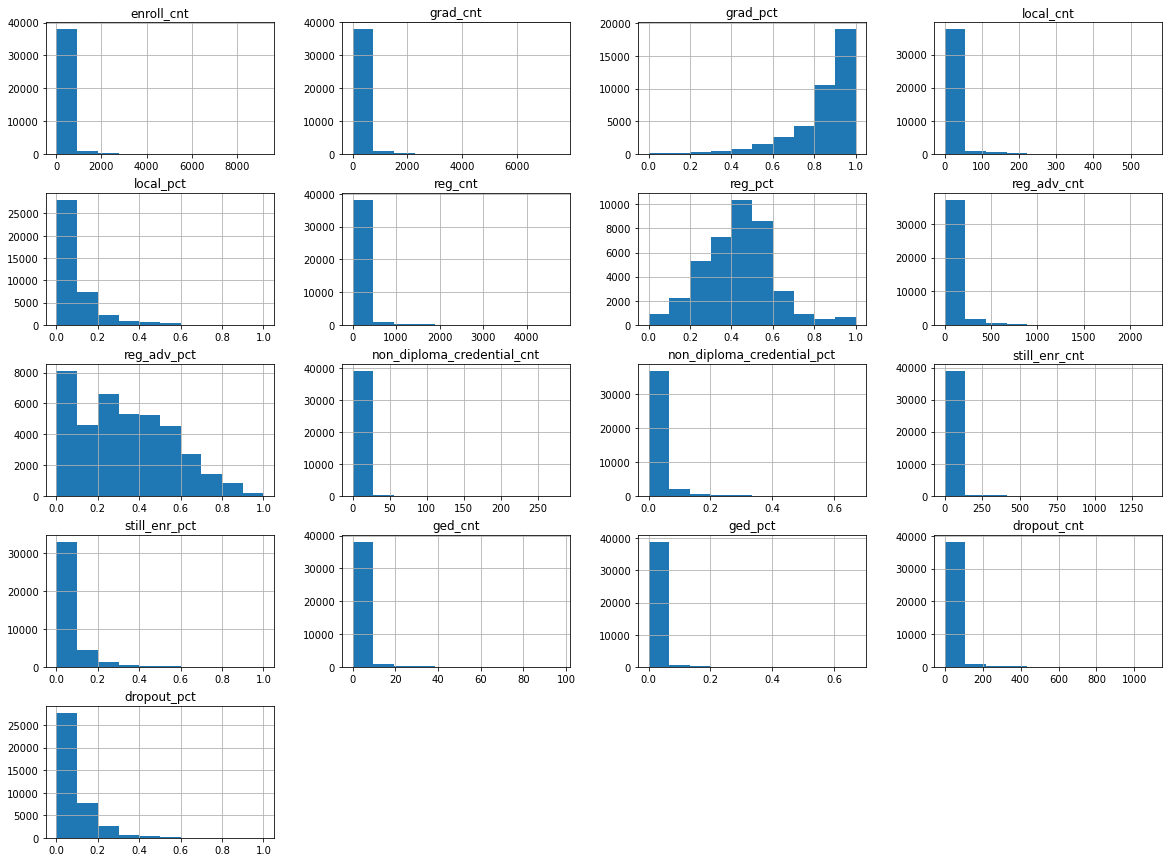

In [13]:
clean_data.iloc[:,6:].hist(bins=10, figsize=(20,15))
plt.show()

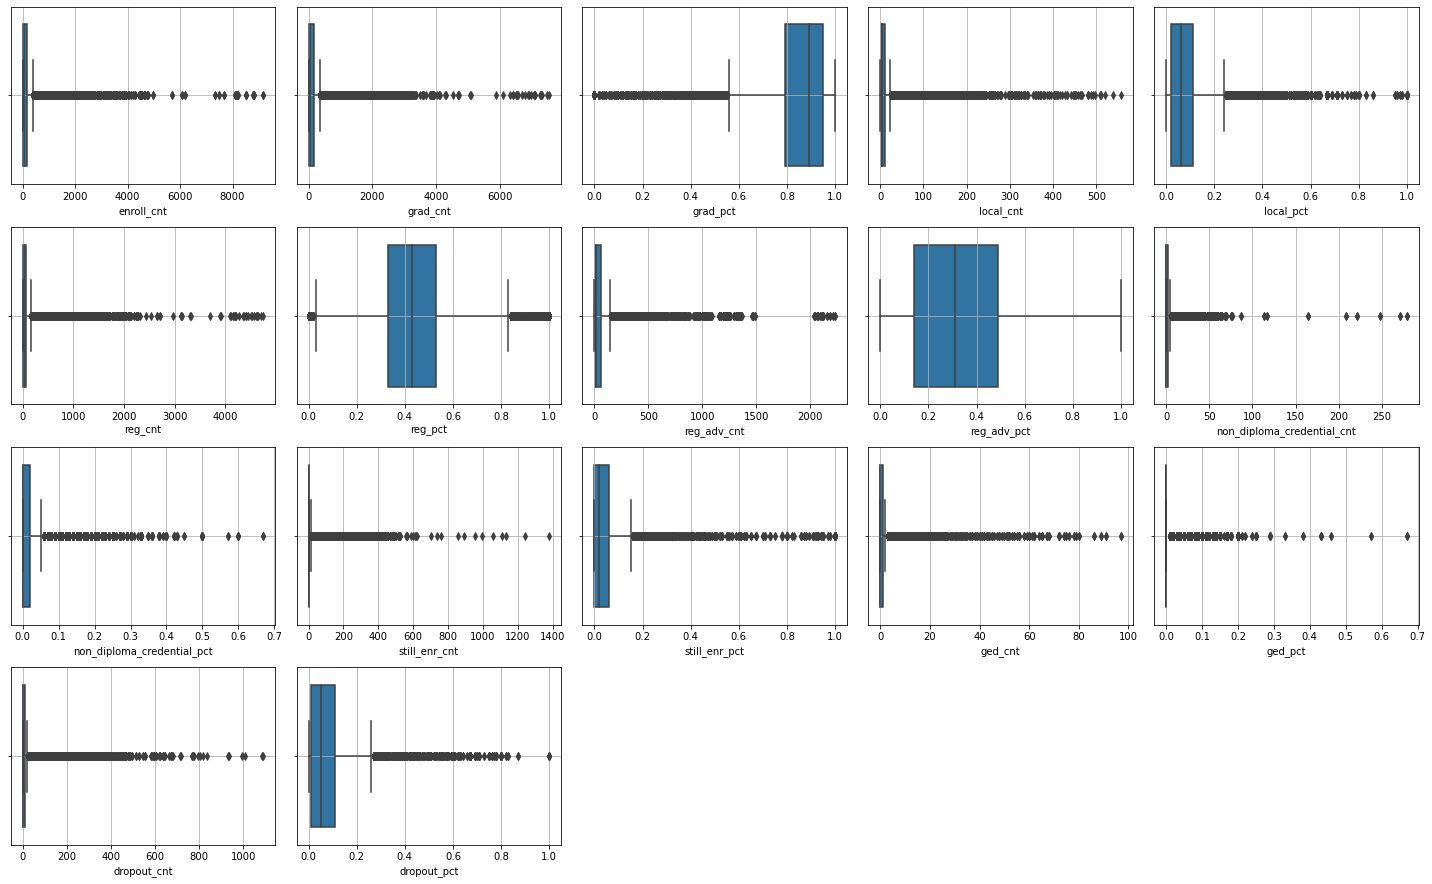

In [14]:
df_numeric = clean_data.iloc[:,6:]
import warnings
warnings.filterwarnings('ignore')

plt.figure(figsize = (20, 15))
for i, col in enumerate(list(df_numeric)):
    plt.subplot(5, 5, i + 1)
    sns.boxplot(df_numeric[col])
    plt.grid()
    plt.tight_layout()

As can be seen in the histograms above, most of the variables resemble a distribution similar to that of dropout_cnt, meaning that they are likely either significant or multicolinear. A lot of the variables are likely to be closely connected, and not just the "cnt"s with their respective "pct"s. Based on the correlation table below, we can see that for the most part, all of the variables are highly correlated with one another. Based on domain knowledge, this makes a lot of sense seeing as these variables put together describe the timeline of a student, from being enrolled, scoring on the regents, graduating, and many other possible combinations. Additionally, any student observed will belong to multiple categories. For instance, by virtue of being included in the enroll_cnt at the beginning of the year, they must belong to one of the various categories of student at the end of the year. That is why if you check the table below, enroll_cnt has the highest overall correlation with the other variables. While this is a good sign moving forward in terms of selecting numeric variables for our model, we must be careful not to include any variables that are multicolinear so as not to overfit the data. One variable that will need to be taken out is dropout_pct. This is because It is directly correlated to dropout_cnt and will only cause noise and inflate scoring metrics.

We also perform a correlation matrix and correlation checks, we see that we need to perform a multicollinearity check among the various variables.

In [15]:
corr_matrix = df_numeric.corr()
corr_matrix['dropout_cnt'].sort_values(ascending = False)


dropout_cnt                   1.000000
local_cnt                     0.871071
reg_cnt                       0.851021
enroll_cnt                    0.846691
grad_cnt                      0.795895
ged_cnt                       0.793304
still_enr_cnt                 0.662578
non_diploma_credential_cnt    0.584549
reg_adv_cnt                   0.508226
dropout_pct                   0.230815
still_enr_pct                 0.085551
reg_pct                       0.070032
ged_pct                       0.058422
local_pct                     0.004871
non_diploma_credential_pct   -0.025518
reg_adv_pct                  -0.184940
grad_pct                     -0.190834
Name: dropout_cnt, dtype: float64

<AxesSubplot:>

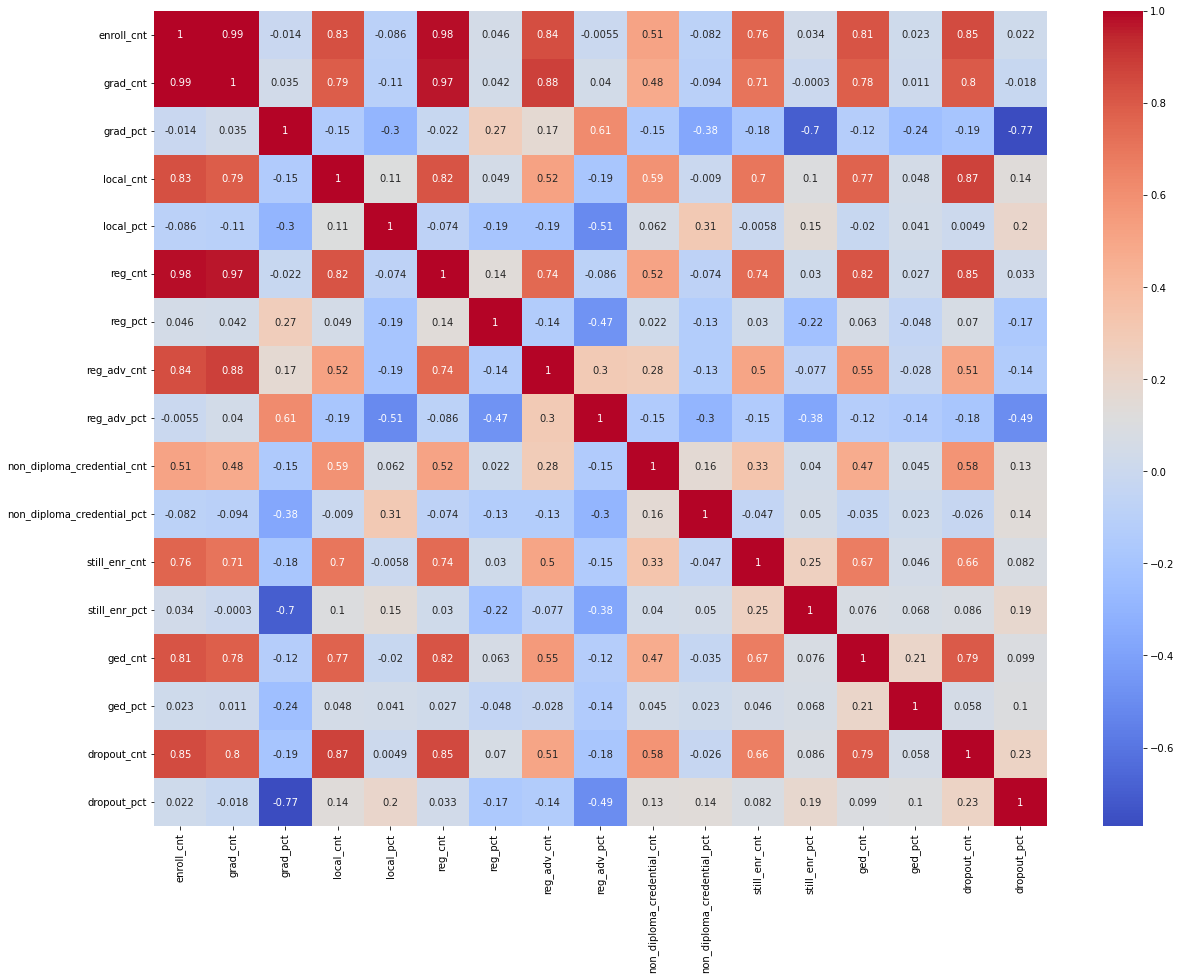

In [16]:
plt.figure(figsize=(20, 15))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm')

In [17]:
clean_data[['enroll_cnt','grad_cnt','local_cnt','reg_cnt','reg_adv_cnt','non_diploma_credential_cnt','still_enr_cnt','ged_cnt','dropout_cnt', 'dropout_pct']].corr()

,enroll_cnt,grad_cnt,local_cnt,reg_cnt,reg_adv_cnt,non_diploma_credential_cnt,still_enr_cnt,ged_cnt,dropout_cnt,dropout_pct
enroll_cnt,1.000000,0.993603,0.831018,0.979747,0.836960,0.511030,0.762840,0.814510,0.846691,0.021982
grad_cnt,0.993603,1.000000,0.790687,0.971027,0.878928,0.478744,0.708722,0.783183,0.795895,-0.018238
local_cnt,0.831018,0.790687,1.000000,0.817128,0.520575,0.587427,0.701385,0.767464,0.871071,0.135475
reg_cnt,0.979747,0.971027,0.817128,1.000000,0.744442,0.515351,0.737750,0.820034,0.851021,0.033453
reg_adv_cnt,0.836960,0.878928,0.520575,0.744442,1.000000,0.284526,0.504600,0.551338,0.508226,-0.139211
non_diploma_credential_cnt,0.511030,0.478744,0.587427,0.515351,0.284526,1.000000,0.333619,0.474265,0.584549,0.129604
still_enr_cnt,0.762840,0.708722,0.701385,0.737750,0.504600,0.333619,1.000000,0.674020,0.662578,0.081946
ged_cnt,0.814510,0.783183,0.767464,0.820034,0.551338,0.474265,0.674020,1.000000,0.793304,0.099411
dropout_cnt,0.846691,0.795895,0.871071,0.851021,0.508226,0.584549,0.662578,0.793304,1.000000,0.230815
dropout_pct,0.021982,-0.018238,0.135475,0.033453,-0.139211,0.129604,0.081946,0.099411,0.230815,1.000000


As shown in the below charts, the data are far from normally or uniformly distributed. In fact, most of these plots skew in a similar direction and slope which would seemingly indicate that these categorical variables are very important in selecting the right model to predict dropout_cnt. While this seems to be great, based on domain knowledge there is a high chance of multicolinearity which needs to be taken into consideration. For example, the county_name may be correlated with nyc_ind since nyc_ind is a binary variable and all counties are either in or are not in NYC. These relationships will need to be _very_ carefully examined in following steps.

<AxesSubplot:>

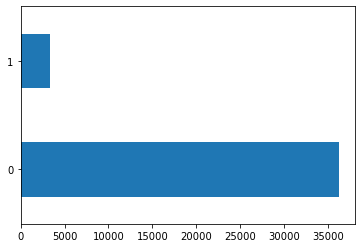

In [18]:
clean_data['nyc_ind'].value_counts().plot(kind='barh')

<AxesSubplot:>

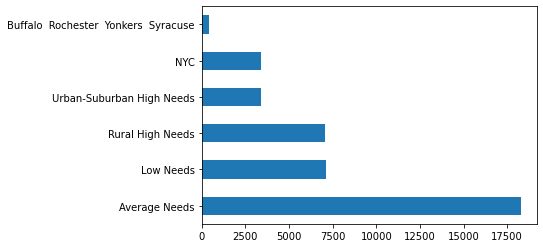

In [19]:
clean_data['nrc_desc'].value_counts().plot(kind='barh')

<AxesSubplot:>

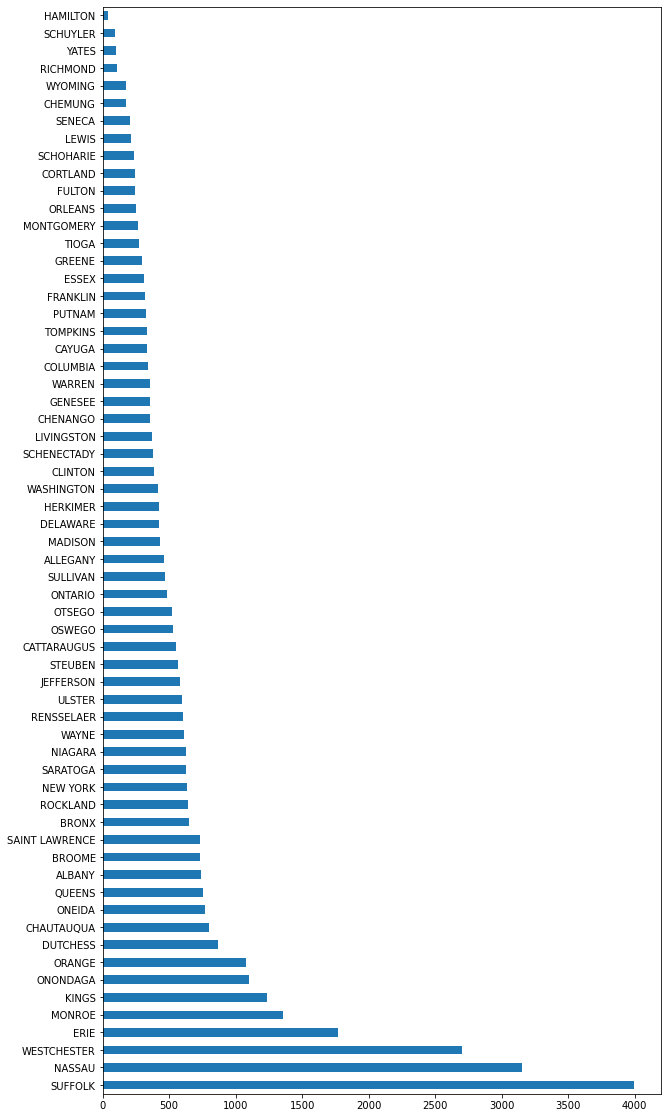

In [20]:
clean_data['county_name'].value_counts().plot(kind = 'barh', figsize = (10,20))

<AxesSubplot:>

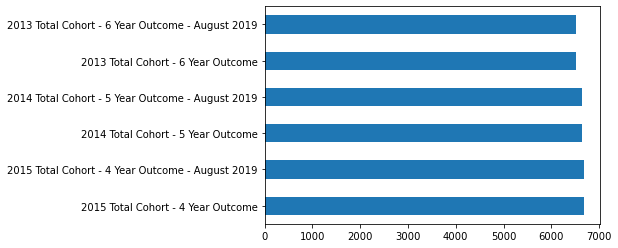

In [21]:
clean_data['membership_desc'].value_counts().plot(kind='barh')

<AxesSubplot:>

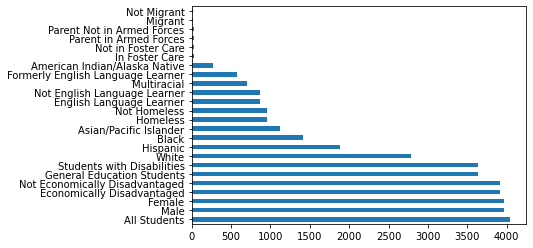

In [22]:
clean_data['subgroup_name'].value_counts().plot(kind='barh')

In [23]:
clean_data.dtypes

aggregation_name               object
nrc_desc                       object
county_name                    object
nyc_ind                         int64
membership_desc                object
subgroup_name                  object
enroll_cnt                    float64
grad_cnt                      float64
grad_pct                      float64
local_cnt                     float64
local_pct                     float64
reg_cnt                       float64
reg_pct                       float64
reg_adv_cnt                   float64
reg_adv_pct                   float64
non_diploma_credential_cnt    float64
non_diploma_credential_pct    float64
still_enr_cnt                 float64
still_enr_pct                 float64
ged_cnt                       float64
ged_pct                       float64
dropout_cnt                   float64
dropout_pct                   float64
dtype: object

## Multicollinearity Check

We perform a check for multicollinearity on the numeric columns. We can see based on the VIF score, that grad_cnt and grad_pct have extremely high VIF values and will likely need to be removed.

In [24]:
df_numeric.columns

Index(['enroll_cnt', 'grad_cnt', 'grad_pct', 'local_cnt', 'local_pct',
       'reg_cnt', 'reg_pct', 'reg_adv_cnt', 'reg_adv_pct',
       'non_diploma_credential_cnt', 'non_diploma_credential_pct',
       'still_enr_cnt', 'still_enr_pct', 'ged_cnt', 'ged_pct', 'dropout_cnt',
       'dropout_pct'],
      dtype='object')

In [25]:
df_numeric_1 = df_numeric.drop('dropout_cnt', 1)

In [26]:
data = df_numeric
# Remove the response from the dataset
Y = clean_data["dropout_cnt"]
iv = df_numeric_1.columns
X = df_numeric_1[iv]
 
# calculate the variance inflation factor
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
 
# compare with each column
[vif(data[iv].values, index) for index in range(len(iv))]
 
# Removing multicollinearity from the dataset using vif
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
 
# compare with each columns
for i in range(len(iv)):
    vif_list = [vif(data[iv].values, index) for index in range(len(iv))]
    maxvif = max(vif_list)
    print("Max VIF value is ", maxvif)                     
    drop_index = vif_list.index(maxvif)
    print("For Independent variable", iv[drop_index])
    
    if maxvif > 10:
        
        print("Deleting", iv[drop_index])
        iv = iv.delete(drop_index)
        print("Final Independent_variables ", iv)


Max VIF value is  inf
For Independent variable grad_cnt
Deleting grad_cnt
Final Independent_variables  Index(['enroll_cnt', 'grad_pct', 'local_cnt', 'local_pct', 'reg_cnt',
       'reg_pct', 'reg_adv_cnt', 'reg_adv_pct', 'non_diploma_credential_cnt',
       'non_diploma_credential_pct', 'still_enr_cnt', 'still_enr_pct',
       'ged_cnt', 'ged_pct', 'dropout_pct'],
      dtype='object')
Max VIF value is  24231.279021393402
For Independent variable grad_pct
Deleting grad_pct
Final Independent_variables  Index(['enroll_cnt', 'local_cnt', 'local_pct', 'reg_cnt', 'reg_pct',
       'reg_adv_cnt', 'reg_adv_pct', 'non_diploma_credential_cnt',
       'non_diploma_credential_pct', 'still_enr_cnt', 'still_enr_pct',
       'ged_cnt', 'ged_pct', 'dropout_pct'],
      dtype='object')
Max VIF value is  659.0808459064418
For Independent variable enroll_cnt
Deleting enroll_cnt
Final Independent_variables  Index(['local_cnt', 'local_pct', 'reg_cnt', 'reg_pct', 'reg_adv_cnt',
       'reg_adv_pct', 'non_d

### Data Preparation

Initially splitting the data into dummy variables produces way too many columns and this needs to be addressed. Going back to the EDA of the categorical values, membership_desc is a nearly uniform distribution so it can likely be eliminated. Additionally, aggregation_name has 680 unique values, which for a categorical value seems like a lot and risks introducing too much variance and potentially overfitting the model so these can be removed. Now that this is taken care of it's a much more manageable 102 after setting the amount of dummies to N-1.

In this step we also drop the columns from the multicollinearity check.

In [27]:
X = clean_data.drop(columns=['dropout_cnt', 'grad_cnt', 'grad_pct', 'enroll_cnt', 'reg_cnt', 'membership_desc','aggregation_name']).copy()
y = clean_data[['dropout_cnt']]

In [28]:
X_dummied = pd.get_dummies(X, drop_first=True)
X_dummied.shape

(39674, 102)

## Feature Selection

For our two versions of each model, we will be using the two different data sets provided by the following two different feature selection models. The first is a LassoCV model and the second is Extra Trees Classifier model.

In [29]:
# libraries
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel

#Fit the model
clf = LassoCV().fit(X_dummied, y)

#Selected features
importance = np.abs(clf.coef_)
idx_third = importance.argsort()[-3]
threshold = importance[idx_third] + 0.01
idx_features = (-importance).argsort()[:10]

feature_name = X_dummied.columns[idx_features]
feature_name

Index(['ged_cnt', 'local_cnt', 'non_diploma_credential_cnt', 'still_enr_cnt',
       'reg_adv_cnt', 'nyc_ind', 'county_name_WASHINGTON',
       'county_name_WARREN', 'county_name_ULSTER', 'county_name_TOMPKINS'],
      dtype='object')

In [30]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel


clf = ExtraTreesClassifier()
clf = clf.fit(X_dummied, y)

model = SelectFromModel(clf, prefit=True)
feature_idx = model.get_support()
feature_name = X_dummied.columns[feature_idx]
feature_name

Index(['local_cnt', 'local_pct', 'reg_pct', 'reg_adv_cnt', 'reg_adv_pct',
       'non_diploma_credential_cnt', 'non_diploma_credential_pct',
       'still_enr_cnt', 'still_enr_pct', 'ged_cnt', 'ged_pct', 'dropout_pct'],
      dtype='object')

What is interesting about the first set of features, is that it includes several counties and a NYC indicator. This may tell us that the school system in specific counties, as well as being in NYC or outside NYC, can have a great effect on drop out rate.

# **Regression Modeling**

After data preparation and feature selection, we decided to select variables based on the outputs of the two methods and see if one was better than the other and which model works best for this sort of data.

**Poisson Regression Model 1**

In [31]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

In [46]:
X1 = X_dummied[['ged_cnt', 'local_cnt', 'non_diploma_credential_cnt', 'still_enr_cnt', 'reg_adv_cnt', 'nyc_ind', 'county_name_WASHINGTON', 'county_name_WARREN', 'county_name_ULSTER', 'county_name_TOMPKINS']].copy()
Y1 = y

In [47]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1,Y1, test_size = 0.3, random_state = 42)

In [48]:
poisson_training_results1 = sm.GLM(Y1_train, X1_train, family=sm.families.Poisson()).fit()

In [49]:
poisson_training_results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            dropout_cnt   No. Observations:                27771
Model:                            GLM   Df Residuals:                    27761
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -5.6263e+05
Date:                Sun, 26 Jun 2022   Deviance:                   1.0445e+06
Time:                        23:03:16   Pearson chi2:                 7.32e+06
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
ged_cnt                       -0.0073      0.000    -31.506      0.000      -0.008      -0.007
local_cnt                      0.0090   3.14e-05    284.957      0.000       0.009       0.009
non_diploma_credential_cnt     0.0095   5.57e-05    169.801      0.000       0.009       0.010
still_enr_cnt                  0.0013   1.28e-05    105.091      0.000       0.001       0.001
reg_adv_cnt                   -0.0003   6.71e-06    -50.686      0.000      -0.000      -0.000
nyc_ind                        3.5066      0.003   1027.025      0.000       3.500       3.513
county_name_WASHINGTON         1.4233      0.028     51.002      0.000       1.369       1.478
county_name_WARREN             1.4557      0.032     45.824      0.000       1.393       1.518
county_name_ULSTER             2.2521      0.015    148.296      0.000       2.222       2.282
county_name_TOMPKINS           1.6296      0.029     57.130      0.000       1.574       1.686
==============================================================================================
"""

For the first Poisson regression model above, the variables were chosen based on the first feature selection output. In this case, each variable has an extremely low p value, indicating that they are in fact significant. However, the log likelihood is extremely low and the residual degrees of freedom are so high that they don't appear on most chi-squared tables to check.

**Poisson Regression Model 2**

In [56]:
X2 = X_dummied[['local_cnt', 'reg_pct', 'reg_adv_cnt', 'non_diploma_credential_cnt', 'still_enr_cnt']].copy()
Y2 = y

In [57]:
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size = 0.3, random_state = 42)

In [58]:
poisson_training_results2 = sm.GLM(Y2_train, X2_train, family=sm.families.Poisson()).fit()

In [59]:
poisson_training_results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            dropout_cnt   No. Observations:                27771
Model:                            GLM   Df Residuals:                    27766
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -4.5340e+05
Date:                Sun, 26 Jun 2022   Deviance:                   8.2599e+05
Time:                        23:10:09   Pearson chi2:                 1.83e+06
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
local_cnt                      0.0118   1.77e-05    669.504      0.000       0.012       0.012
reg_pct                        4.1810      0.003   1291.638      0.000       4.175       4.187
reg_adv_cnt                   -0.0009   5.42e-06   -167.569      0.000      -0.001      -0.001
non_diploma_credential_cnt     0.0147   4.32e-05    339.927      0.000       0.015       0.015
still_enr_cnt                  0.0025   1.15e-05    214.468      0.000       0.002       0.002
==============================================================================================
"""

In this model as well, each variable has an extremely low p value indicating that they are relevant. In this case also, the residual degrees of freedom and log likelihood metrics are very bad. However, this model performs better than the other model seeing as the log-likelihood is higher. Based on domain knowledge and decision making, certain variables in the second selection set were excluded.

**Negative Binomial Regression Model 1**

In [60]:
nb1_training_results = sm.GLM(Y1_train, X1_train,family=sm.families.NegativeBinomial()).fit()

In [61]:
print(nb1_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            dropout_cnt   No. Observations:                27771
Model:                            GLM   Df Residuals:                    27761
Model Family:        NegativeBinomial   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -94163.
Date:                Sun, 26 Jun 2022   Deviance:                   1.7434e+05
Time:                        23:11:33   Pearson chi2:                 1.48e+05
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
ged_cnt             

In this negative binomial model, we stuck with the first set again to see if maybe this method would give better results. The log likelihood is significantly better than the Poisson model which is a good sign and the p value of the variables are again significant. However, again the degrees of freedom are still higher than desired.

**Negative Binomial Regression Model 2**

In [62]:
nb2_training_results = sm.GLM(Y2_train, X2_train,family=sm.families.NegativeBinomial()).fit()

In [63]:
print(nb2_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            dropout_cnt   No. Observations:                27771
Model:                            GLM   Df Residuals:                    27766
Model Family:        NegativeBinomial   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -85518.
Date:                Sun, 26 Jun 2022   Deviance:                       42933.
Time:                        23:12:21   Pearson chi2:                 6.59e+04
No. Iterations:                    61                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
local_cnt           

In this second negative binomial model, again the variables all have low p values and in compared to its counterpart in the Poisson model, the log likelihood is significantly better, even compared to the other negative binomial model. While this does tell us that this model is better used, there is no indication that this is a good model since there are still a large degrees of freedom.

**Multiple Linear Regression Model 1**

In [64]:
import statsmodels.api as sm
# with statsmodels
X_mlr = sm.add_constant(X1) # adding a constant
 
model = sm.OLS(y, X_mlr).fit()
predictions = model.predict(X_mlr) 
 
print_model = model.summary()
print(print_model)


                            OLS Regression Results                            
Dep. Variable:            dropout_cnt   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                 1.635e+04
Date:                Sun, 26 Jun 2022   Prob (F-statistic):               0.00
Time:                        23:13:10   Log-Likelihood:            -1.7920e+05
No. Observations:               39674   AIC:                         3.584e+05
Df Residuals:                   39663   BIC:                         3.585e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

Based on this output we can confidently say that this is the best model for this selection of features thus far. The adjusted R-squared is a very respectable 80.5% and the f-statistic is very high compared to the null hypothesis.

**Multiple Linear Regression Model 2**

In [65]:
X_mlr_2 = sm.add_constant(X2) # adding a constant
 
model_2 = sm.OLS(y, X_mlr_2).fit()
predictions_2 = model_2.predict(X_mlr_2) 
 
print_model_2 = model_2.summary()
print(print_model_2)

                            OLS Regression Results                            
Dep. Variable:            dropout_cnt   R-squared:                       0.778
Model:                            OLS   Adj. R-squared:                  0.778
Method:                 Least Squares   F-statistic:                 2.782e+04
Date:                Sun, 26 Jun 2022   Prob (F-statistic):               0.00
Time:                        23:15:59   Log-Likelihood:            -1.8174e+05
No. Observations:               39674   AIC:                         3.635e+05
Df Residuals:                   39668   BIC:                         3.635e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In this model, the R-squared is still respectable at 77.8% but lower than the first model. However, the f-statistic is much better than that first model at rejecting the null hypothesis. An explanation for the lower R-squared value may be that there aren't enough variables included but there are enough to srongly reject the null hypothesis.

# Select Models

Looking at all selections of features and models, it is clear that multiple linear regression is best for predicting the target variable, especially given the variables represented. With the other types of models, they were utterly terrible at predicting, not even close to really satisfying results. With the multiple linear regression, it is much closer to giving us the ideal result. Given all of the information gathered, we would select the second multiple linear model as our model to move forward. While it's not perfect and the R-squared value is slightly lower than desired, this can be corrected by identifying a couple more significant variables and the f-statistic is higher than the other to prove that the null hypothesis is incorrect. The coefficients are somewhat similar between the models. Even though the size of the coefficients varies between models, comparing the two selections coefficients, the trends stay the same.

# Conclusion

While trying to predict something as common as a dropout, as unfortunate as it may be, the multiple linear regression seems to be the best model. This can be further explained based on what the target variable is. Unfortunately, a student dropping out of school isn't very uncommon. However, the number is not consistent to predict so this target is not a good fit for Poisson and negative binomial. This is something that is a perfect fit for linear models for those reasons.